In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')  # 更改绘图风格 R语言绘图库的风格
plt.rcParams['font.family']='SimHei'
plt.rcParams['axes.unicode_minus']= False

In [107]:
userdata=pd.read_csv('userdata.csv')

In [108]:
userdata['Date'].value_counts()

2017-12-02    1376713
2017-12-03    1363677
2017-12-01    1082387
2017-11-30    1043015
2017-11-29    1028342
2017-11-27    1008967
2017-11-28     986162
Name: Date, dtype: int64

In [109]:
userdata['Type'].value_counts()

pv      7064791
cart     437025
fav      227271
buy      160176
Name: Type, dtype: int64

In [110]:
#RFM,由于缺少M（金额）列，仅通过R（最近一次购买时间）和F（消费频率）对用户进行价值分析
buy_group = userdata[userdata['Type']=='buy']

In [111]:
buy_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160176 entries, 102 to 7889163
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   160176 non-null  int64 
 1   User_Id      160176 non-null  int64 
 2   Sku_Id       160176 non-null  int64 
 3   Category_Id  160176 non-null  int64 
 4   Type         160176 non-null  object
 5   Timestamp    160176 non-null  object
 6   Date         160176 non-null  object
 7   Time         160176 non-null  object
dtypes: int64(4), object(4)
memory usage: 11.0+ MB


In [112]:
recenct_day=pd.to_datetime('2017-12-04')-pd.to_datetime(buy_group['Date'])

recency = {'Recency':recenct_day.values}
recency = pd.DataFrame(recency,index =recenct_day.index )

R_data = buy_group.join(recency)


In [113]:
times = R_data.groupby(by = 'User_Id').count()['Type']

frequence = {'Frequence':times.values,'User_Id':times.index}
F_data = pd.DataFrame(frequence)

In [114]:
RF_data = R_data.merge(F_data,on="User_Id",how="left") 
RF_data.head()

,Unnamed: 0,User_Id,Sku_Id,Category_Id,Type,Timestamp,Date,Time,Recency,Frequence
0,23649307,251445,2201791,339305,buy,2017-12-03 09:38:46,2017-12-03,09:38:46,1 days,3
1,72372292,643368,1068800,4048584,buy,2017-11-27 12:23:32,2017-11-27,12:23:32,7 days,1
2,69123600,494873,1447767,3645362,buy,2017-11-29 16:03:27,2017-11-29,16:03:27,5 days,1
3,6878740,394729,4449808,903809,buy,2017-11-30 13:37:18,2017-11-30,13:37:18,4 days,1
4,62061050,178833,303177,3645362,buy,2017-11-30 17:25:42,2017-11-30,17:25:42,4 days,1


In [115]:
RF_data['Recency'].dtype
RF_data['Recency'] = RF_data['Recency']/np.timedelta64(1, 'D')
RF_data['Recency']=RF_data['Recency'].astype('int64')
RF_data.quantile()

Unnamed: 0     50062624.0
User_Id          511061.0
Sku_Id          2593548.0
Category_Id     2640118.0
Recency               4.0
Frequence             1.0
Name: 0.5, dtype: float64

In [116]:
RF_data['R']=(RF_data['Recency']).apply(lambda x: '1' if x <=4 else '0')
RF_data['F']=(RF_data['Frequence']).apply(lambda x: '1' if x >1 else '0')

In [117]:
def rmf(r,f):
    if r=="1" and f=="1":
        return "重要价值客户"
    elif r=="0" and f=="1":
        return "重要保持客户"
    elif r=="1" and f=="0":
        return "重要挽留客户"
    else:
        return "一般发展客户"
    
RF_data['RF']=RF_data.apply(lambda row: rmf(row['R'], row['F']), axis=1)
RF_data.head()

,Unnamed: 0,User_Id,Sku_Id,Category_Id,Type,Timestamp,Date,Time,Recency,Frequence,R,F,RF
0,23649307,251445,2201791,339305,buy,2017-12-03 09:38:46,2017-12-03,09:38:46,1,3,1,1,重要价值客户
1,72372292,643368,1068800,4048584,buy,2017-11-27 12:23:32,2017-11-27,12:23:32,7,1,0,0,一般发展客户
2,69123600,494873,1447767,3645362,buy,2017-11-29 16:03:27,2017-11-29,16:03:27,5,1,0,0,一般发展客户
3,6878740,394729,4449808,903809,buy,2017-11-30 13:37:18,2017-11-30,13:37:18,4,1,1,0,重要挽留客户
4,62061050,178833,303177,3645362,buy,2017-11-30 17:25:42,2017-11-30,17:25:42,4,1,1,0,重要挽留客户


In [118]:
rmf_data = RF_data['RF'].value_counts()
rmf_data

重要挽留客户    68574
一般发展客户    47164
重要价值客户    25751
重要保持客户    18687
Name: RF, dtype: int64

Text(0.5, 1.0, 'RF用户分层')

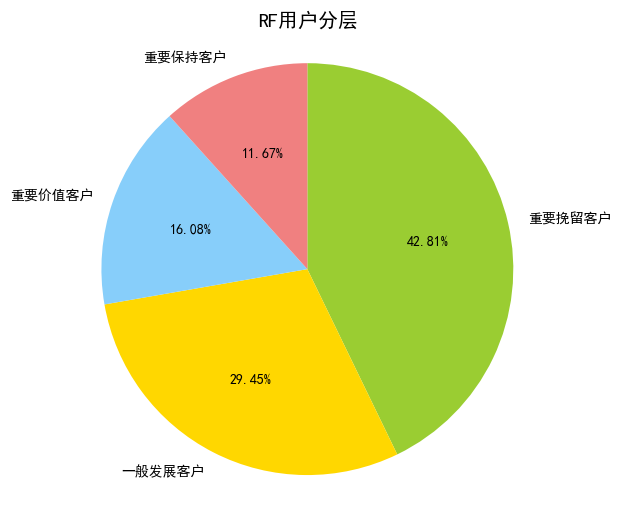

In [119]:
RFM_pie = RF_data['RF'].value_counts().reset_index()
RFM_pie['Rate'] = RFM_pie['RF'] / RFM_pie['RF'].sum()
fig, ax = plt.subplots(figsize=[16,6])
plt.pie(RFM_pie['Rate'], labels = RFM_pie['index'], startangle = 90,autopct="%1.2f%%",
        counterclock = False,colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral'])
plt.axis('square')
plt.title('RF用户分层')

In [120]:
#留存分析
# 按日期排序
userdata2 = userdata.sort_values('Date')

In [121]:
userdata['Date'] = pd.to_datetime(userdata['Date'])

In [122]:
# 计算第一天活跃过的用户
first_day_users = set(userdata[userdata['Date'] == '2017-11-27']['User_Id'])

In [123]:
# 计算次日留存率
next_day_users = set(userdata[userdata['Date'] == '2017-11-28']['User_Id'])
next_day_retention = len(next_day_users.intersection(first_day_users)) / len(first_day_users)
next_day_retention

0.5268120241770841

In [124]:
# 计算七日留存率
seven_day_users = set(userdata[userdata['Date']== '2017-12-03']['User_Id'])
seven_day_retention = len(seven_day_users.intersection(first_day_users)) / len(first_day_users)
seven_day_retention

0.5953883519555881

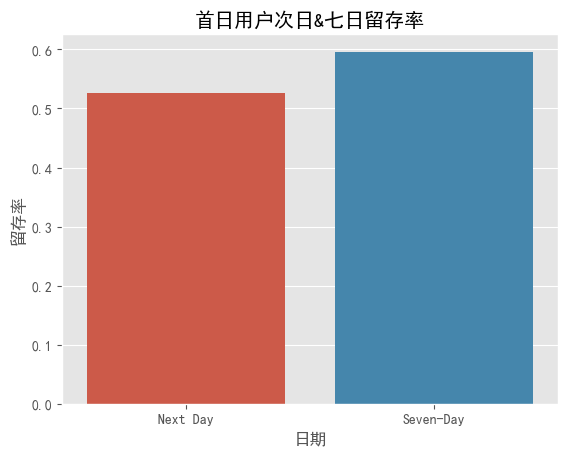

In [125]:
# 绘制次日留存率和七日留存率的柱状图
retention_data = {'Retention Rate': [next_day_retention, seven_day_retention], 'Days': ['Next Day', 'Seven-Day']}
retention_df = pd.DataFrame(retention_data)

sns.barplot(x='Days', y='Retention Rate', data=retention_df)
plt.xlabel('日期')
plt.ylabel('留存率')
plt.title('首日用户次日&七日留存率')
plt.show()

In [ ]:
#五六成的留存率，第七日比次日更高，看日期可知第七日为周末，周末量大回流了。